# **Telemetry-Based Capacity Analysis for LAMAs**

---

**Author:** [alesancor1](https://github.com/alesancor1)

**License:** [GNU GPLv3](https://www.gnu.org/licenses/gpl-3.0.html)

**Last modified:** 2023-05-30

---

### **Summary**
This showcase is intended to demonstrate the aplicability of telemetry to the Capacity Analysis process through the use of RESTSense. Capacity Analysis encompasses the analysis of capacity, a complex metric derived as a consequence of the interaction of microservices architectures (MSAs) with external services that establish rate limitations. These rate limitations forces the MSA to be aware of them, and for instance, this MSAs are refered to as Limitation-Aware Microservice Architectures (LAMAs). Thus, in order to evaluate the ability of RESTSense to provide valuable insights into the analysis process, we have prepared a test architecture that consists of a set of microservices (MSA) that are deployed using docker-compose. These services interact with external APIs, such as GitHub, converting this MSA into a LAMA. The TestBed is composed of the following three microservices, developped based on the [Generic API Requester](https://github.com/alesancor1/api-requester) project. Results show that RESTSense is able to successfully infer the inputs required for the capacity analysis based on the telemetry data, and thus, contributes to the automation of the capacity analysis process.

### **Contents**

1. [Introduction](#1.-introduction)
   1. [Objectives](#1.1-objectives)
   2. [TestBed](#1.2-testbed)
2. [Data Extraction](#2.-data-extraction)
   1. [Prerequisites](#2.1-prerequisites)
   2. [Data loading](#2.2-data-loading)
   3. [Preprocessing](#2.3-preprocessing)
3. [Exploratory Data Analysis](#3.-exploratory-data-analysis)
   1. [Data visualization](#3.1-data-visualization)
   2. [Inferring topology](#3.2-inferring-topology)
4. [Capacity Analysis](#4.-capacity-analysis)
   1. [LAMA creation](#4.1-lama-creation)
   2. [Analysis](#4.2-analysis)
   3. [Results](#4.3-results)
5. [Limitations](#5.-limitations)
6. [Conclusions](#6.-conclusions)

---

### **1. Introduction**
This notebooks serves as an introduction to capacity analysis and telemetry integration using RESTSense. In this section, we will provide an overview of the purpose and scope of this showcase, highlighting the significance of telemetry in the capacity analysis process.

Capacity analysis involves assessing the capabilities and limitations of a system, particularly in the context of microservices architectures (MSAs) interacting with external services. These interactions often introduce rate limitations that MSAs must take into account, which converts the MSAs into Limitation-Aware Microservice Architectures (LAMAs). Understanding and optimizing capacity is crucial for ensuring the smooth functioning and optimal performance of these systems.

To facilitate the evaluation of RESTSense's effectiveness in providing valuable insights for capacity analysis, we have prepared a test architecture consisting of a set of microservices (MSAs) deployed using docker-compose. These services interact with external APIs, such as GitHub, transforming our MSA into a LAMA. By leveraging RESTSense, we aim to automate the capacity analysis process and enhance our understanding of system behavior.

In the subsequent sections, we will present specific objectives of this showcase and explore the TestBed, which comprises three microservices developed based on the [Generic API Requester](https://github.com/alesancor1/api-requester) project. Furthermore, we will present the results obtained from applying RESTSense to infer the necessary inputs for capacity analysis based on the telemetry data.

#### **1.1 Objectives**

The primary objective of this showcase is to demonstrate the applicability of telemetry to the capacity analysis process. To this end, we will leverage RESTSense to infer the inputs required for capacity analysis based on the telemetry data.


#### **1.2 TestBed**

As mentioned before, the Testbed consists of three microservices developed based on the Generic API Requester project. The microservices interact with external APIs, such as GitHub, and are deployed using docker-compose. The following figure illustrates the TestBed architecture:

<center>
<img src="./testbed/architecture.png" alt="TestBed" width="600"/>
<figcaption><i>Fig.1 - Architecture of the Testbed</i></figcaption>
</center>

This architecture has been built thanks to the flexibility of the Generic API Requester, which allows to easily create new microservices by simply deploying a new docker container and sending the desired requests to make in JSON format. This way, it is possible to model multiple architectures with different topologies and interactions with external APIs.

---

### **2. Data Extraction**

The data extraction process is performed in two primary steps: data loading and preprocessing. The data loading step consists of loading the data from the database into a pandas dataframe. The preprocessing step consists of cleaning the data and extracting the relevant information from it.

The is reported by the [RESTSense Agent](https://github.com/restsense/agent) and collected by [RESTSense Collector](https://github.com/restsense/collector), then parsed and stored in a MongoDB database afterwards. Once stored, the data is extracted from the database into a CSV file using the [MongoDB Compass](https://www.mongodb.com/products/compass) tool. CSV files can be found in the `data` directory.

#### **2.1 Prerequisites**

The complete process of analysis performed in this notebook has been developed using Python 3.9.13. The following libraries are required to run the notebook:

* [pandas](https://pandas.pydata.org/) - library for data manipulation and analysis.
* [numpy](https://numpy.org/) - library for scientific computing.
* [matplotlib](https://matplotlib.org/) and [plotly](https://plotly.com/) - libraries for data visualization.
* [networkx](https://networkx.org/) - library for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
* [ipaddress](https://docs.python.org/3/library/ipaddress.html) - library for IPv4/IPv6 manipulation library.
* [requests](https://docs.python-requests.org/en/latest/) - library for HTTP requests.
* [json](https://docs.python.org/3/library/json.html) - library for JSON manipulation.

The following code block installs the required libraries:

In [5]:
%reset

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import ipaddress
import requests, json

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### **2.2 Data loading**

To load the data, we will use the `pandas` library. The following code block loads the data from the CSV file into a pandas dataframe:

In [6]:
SPANS = pd.read_csv('data/traces.csv')
RESOURCES = pd.read_csv('data/resources.csv')

We will now show the first 5 rows of each dataframe to get a better understanding of the data, starting with the `RESOURCES` dataframe:

In [8]:
RESOURCES.head(5)

,_id,service.name,service.ip_addr,service.version,__v,process.command,process.command_args.0,process.command_args.1,process.command_args.2,process.command_args.3,process.executable.name,process.executable.path,process.owner,process.pid,process.runtime.description,process.runtime.name,process.runtime.version,telemetry.sdk.language,telemetry.sdk.name,telemetry.sdk.version
0,644f08e8f763118528853e9d,microservice-one,172.19.0.4,unknown,0,/opt/app/index.js,/usr/local/bin/node,-r,@restsense/agent/tracing,/opt/app/index.js,node,/usr/local/bin/node,root,26,Node.js,nodejs,16.13.0,nodejs,opentelemetry,1.12.0
1,644f095af763118528853f0d,microservice-three,172.19.0.3,unknown,0,/opt/app/index.js,/usr/local/bin/node,-r,@restsense/agent/tracing,/opt/app/index.js,node,/usr/local/bin/node,root,26,Node.js,nodejs,16.13.0,nodejs,opentelemetry,1.12.0
2,644f095af763118528853f0f,microservice-two,172.19.0.2,unknown,0,/opt/app/index.js,/usr/local/bin/node,-r,@restsense/agent/tracing,/opt/app/index.js,node,/usr/local/bin/node,root,26,Node.js,nodejs,16.13.0,nodejs,opentelemetry,1.12.0


Now, we will show the first 5 rows of the `SPANS` dataframe:

In [9]:
SPANS.head(5)

,_id,name,span_id,trace_id,parent_span_id,start_time,end_time,attributes.target.net.peer.ip,attributes.target.net.peer.port,attributes.operation.http.url,...,attributes.operation.http.status_text,metadata.scope,metadata.resource_id,metadata.schema_url,__v,attributes.operation.http.response_content_length_uncompressed,attributes.source.net.host.ip,attributes.source.net.host.port,attributes.operation.http.user_agent,attributes.operation.http.request_content_length_uncompressed
0,644f095a8f303ba50af78c43,GET,8ca6e56627ab94ce,a6944968e1866b0987dc3f814e205a50,f3ce3ce0cc5d50f7,2023-05-01T00:35:33.175Z,2023-05-01T00:35:33.617Z,140.82.121.5,443,https://api.github.com/orgs/oas-tools,...,OK,@opentelemetry/instrumentation-http@0.38.0,644f095af763118528853f0d,NaN,0,NaN,NaN,NaN,NaN,NaN
1,644f095a8f303ba50af78c44,POST,c70448d8be8654bc,a6944968e1866b0987dc3f814e205a50,f3ce3ce0cc5d50f7,2023-05-01T00:35:33.191Z,2023-05-01T00:35:33.689Z,172.19.0.2,80,http://microservice-two/api/v1/request,...,OK,@opentelemetry/instrumentation-http@0.38.0,644f095af763118528853f0d,NaN,0,1513.0,NaN,NaN,NaN,NaN
2,644f095a8f303ba50af78c45,POST,eead91e3037ffd84,a6944968e1866b0987dc3f814e205a50,f3ce3ce0cc5d50f7,2023-05-01T00:35:33.196Z,2023-05-01T00:35:33.744Z,172.19.0.2,80,http://microservice-two/api/v1/request,...,OK,@opentelemetry/instrumentation-http@0.38.0,644f095af763118528853f0d,NaN,0,1513.0,NaN,NaN,NaN,NaN
3,644f095a8f303ba50af78c46,POST,308bdc922fc97943,a6944968e1866b0987dc3f814e205a50,f3ce3ce0cc5d50f7,2023-05-01T00:35:33.193Z,2023-05-01T00:35:33.781Z,172.19.0.2,80,http://microservice-two/api/v1/request,...,OK,@opentelemetry/instrumentation-http@0.38.0,644f095af763118528853f0d,NaN,0,1513.0,NaN,NaN,NaN,NaN
4,644f095a8f303ba50af78c47,POST,f3ce3ce0cc5d50f7,a6944968e1866b0987dc3f814e205a50,34bd5c30cdab2436,2023-05-01T00:35:33.120Z,2023-05-01T00:35:33.811Z,::ffff:172.19.0.4,55142,http://microservice-three/api/v1/request,...,OK,@opentelemetry/instrumentation-http@0.38.0,644f095af763118528853f0d,NaN,0,NaN,::ffff:172.19.0.3,80.0,axios/1.4.0,883.0


#### **2.3 Preprocessing**

The preprocessing step consists of cleaning the data and extracting the relevant information from it. The preprocessing steps performed on the `SPANS` dataframe are as follows:

1. Drop the `_id`, `__v`, `metadata.scope`, `name` and `metadata.shema_url` columns, since we will not be using them.
2. Rename the columns to make them more readable.
3. Parse the column values to the appropriate data types.
4. Merge columns that are related to the same concept:
    * `request_method` and `request_url` are merged into `request`.
    * `response_status_code` and `response_status_text` are merged into `response_status`.
5. Drop the merged columns.

In [10]:
# DROP UNNECESSARY COLUMNS
SPANS = SPANS.drop([
    '_id', '__v', 'metadata.scope',
    'name', 'metadata.schema_url'
    ], axis=1)

# RENAME COLUMNS
SPANS = SPANS.rename(columns= {
    'attributes.source.net.host.ip': 'source_ip',
    'attributes.source.net.host.port': 'source_port',
    'attributes.target.net.peer.ip': 'target_ip',
    'attributes.target.net.peer.port': 'target_port',
    'attributes.operation.http.url': 'request_url',
    'attributes.operation.http.method': 'request_method',
    'attributes.operation.http.request_content_length_uncompressed': 'request_content_length',
    'attributes.operation.http.status_code': 'response_status_code',
    'attributes.operation.http.status_text': 'response_status_text',
    'attributes.operation.http.response_content_length_uncompressed': 'response_content_length',
    'attributes.operation.http.user_agent': 'user_agent',
    'attributes.operation.http.host': 'http_host',
    'metadata.resource': 'resource_id',
})

# PARSE COLUMN VALUES
SPANS['start_time'] = pd.to_datetime(SPANS['start_time'])
SPANS['end_time'] = pd.to_datetime(SPANS['end_time'])
SPANS['duration'] = pd.to_timedelta(SPANS['end_time'] - SPANS['start_time']).dt.total_seconds() * 1000
SPANS['request_content_length'] = pd.to_numeric(SPANS['request_content_length'])
SPANS['response_content_length'] = pd.to_numeric(SPANS['response_content_length'])

# MERGE COLUMN VALUES
SPANS['request'] = SPANS['request_method'] + ' ' + SPANS['request_url']
SPANS['response'] = SPANS['response_status_code'].astype(str) + ' ' + SPANS['response_status_text']

# DROP MERGED COLUMNS
SPANS = SPANS.drop(['request_method', 'request_url', 'response_status_code', 'response_status_text'], axis=1)

On the other hand, the preprocessing steps performed on the `RESOURCES` dataframe are as follows:

1. Drop the `__v`, `process.command`, `process.executable.name`, `process.executable.path` and `process.runtime.description` columns, since we will not be using them.
2. Rename the columns to make them more readable.
3. Merge columns that are related to the same concept:
    * The array of arguments of `process.command_args` is joint into `process.command` column.
    * `telemetry_language`, `telemetry_name` and `telemetry_version` are merged into `telemetry_sdk` following the `lang/name:version` format.
    * `runtime_name` and `runtime_version` are merged into `runtime` following the `name:version` format.
4. Drop the merged columns.

In [11]:
# DROP UNNECESSARY COLUMNS
RESOURCES = RESOURCES.drop([
    '__v', 'process.command', 'process.executable.name', 'process.executable.path', 'process.runtime.description'
], axis=1)

RESOURCES = RESOURCES.rename(columns= {
    'service.name': 'service_name',
    'service.version': 'service_version',
    'service.ip_addr': 'service_ip',
    'process.pid': 'pid',
    'process.owner': 'owner',
    'telemetry.sdk.language': 'telemetry_language',
    'telemetry.sdk.name': 'telemetry_name',
    'telemetry.sdk.version': 'telemetry_version',
    'process.runtime.name': 'runtime_name',
    'process.runtime.version': 'runtime_version',
})

# MERGE COLUMN VALUES
RESOURCES['command'] = RESOURCES['process.command_args.0'] + " " + RESOURCES['process.command_args.1'] + " " + RESOURCES['process.command_args.2'] + " " + RESOURCES['process.command_args.3']
RESOURCES['telemetry_sdk'] = RESOURCES['telemetry_language'] + "/" + RESOURCES['telemetry_name'] + ":" + RESOURCES['telemetry_version']
RESOURCES['runtime'] = RESOURCES['runtime_name'] + ":" + RESOURCES['runtime_version']

# DROP MERGED COLUMNS
RESOURCES = RESOURCES.drop([
    'telemetry_language', 'telemetry_name', 'telemetry_version',
    'runtime_name', 'runtime_version', 'process.command_args.0',
    'process.command_args.1', 'process.command_args.2', 'process.command_args.3'
], axis=1)

---

### **3. Exploratory Data Analysis**

In this section, we will perform an exploratory data analysis (EDA) to gain a better understanding of the data. The EDA will consist of data visualization and topology inference. Before proceeding with the EDA, we will first extract the traces from the `SPANS` dataframe.


In [22]:
TRACES = SPANS['trace_id'].unique() # Get traces ids
pd.DataFrame(TRACES, columns=['trace_id']) # Convert to dataframe for visualization

,trace_id
0,a6944968e1866b0987dc3f814e205a50
1,90a55847370e8a1ff966ecbd8df42687
2,1f749818e00792684011b77e5e7183fc
3,c901c229b040e19ec2c947775caf6a5c
4,e41ea1fc90653470882401f8c48bb7b9
5,c754bcc67a3aba739a4b804e5581ab6b
6,61fa3a93d182593af9884a932ff950ed


We will now visualize the data to gain a better understanding of the data. We will first define functions that will help us build different types of graphs.

First, we will sort the `SPANS` dataframe recursively following a depth-first search (DFS) approach. This will allow us to easily extract the traces from the dataframe while respecting the hierarchy of the spans. The following code block defines the recursive function to do so, using tail call optimization to avoid stack overflow:

In [12]:
# SORT SPANS INSIDE A TRACE FOLLOWING THE PARENT-CHILD RELATIONSHIP IN DFS ORDER
def trace_dfs_sort_recursive(trace, parent, acc):
    if len(acc) == len(trace):
        return acc
    else:
        children = trace.loc[trace['parent_span_id'] == parent['span_id']].sort_values(by=['start_time'])
        for i, child in children.iterrows():
            acc = acc.append(child)
            acc = trace_dfs_sort_recursive(trace, child, acc)
        return acc

def trace_dfs_sort(trace_id):
    trace = SPANS.loc[SPANS['trace_id'] == trace_id]
    processed = pd.DataFrame(columns=trace.columns)
    parent = trace.loc[pd.isna(trace['parent_span_id'])].iloc[0]
    processed = processed.append(parent)
    children = trace.loc[trace['parent_span_id'] == parent['span_id']].sort_values(by=['start_time'])
    for i, child in children.iterrows():
        processed = processed.append(child)
        processed = trace_dfs_sort_recursive(trace, child, processed)
    return processed.reset_index(drop=True)

Now, we will define a function to get the hostname of a given IP address. This will allow us to display the hostnames instead of the IP addresses in the graphs. To do so, we will look for the IP address in the `RESOURCES` dataframe and return the hostname if found. It is important to note that this function must be compliant with the [RESTSense datamodel specification](https://github.com/restsense/specification/tree/main/schemas/1.0.0), which states that depending on the type of span, the hostname should be extracted from the HOST header, or from the resource itself. The following code block defines the function: 

In [13]:
# GET THE HOST BASED ON IP
def get_host(span, scope):
    # When no source is declared, it is a request. Thus, thesource is the resource
    if scope == 'source' and pd.isna(span['source_ip']):
        return RESOURCES.loc[RESOURCES['_id'] == span['resource_id']]['service_name'].iloc[0]
    
    # When source does exist, it is a response. Thus, source must match http host
    elif scope == 'source' and not pd.isna(span['source_ip']): 
        return span['http_host']
        
    # When source does exist, it is a response. Thus, we look in resources for the target ip
    elif scope == 'target' and not pd.isna(span['source_ip']):
        host_name = RESOURCES.loc[RESOURCES['service_ip'] == span['target_ip'].replace("::ffff:", '')]['service_name']
        if len(host_name) > 0:
            return host_name.iloc[0]
        else:
            return 'external/uninstrumented'
    
    # On requests, the target is always the http host
    else:
        return span['http_host']

Now we can define a function to build a cascade diagram using [plotly](https://plotly.com/). Cascade diagrams are useful for visualizing the hierarchy of spans, as well as the duration of each span. The following code block defines the function:

In [14]:
def draw_trace(trace_id):
    # Get DFS SORTED TRACE
    TRACE = trace_dfs_sort(trace_id)    

    # ADD SOURCE AND TARGET COLUMNS FOR EXTRA INFORMATION
    TRACE['source'] = TRACE.apply(lambda x: f"{get_host(x, 'source')}({x['source_ip'] + ':' + str(x['source_port']) if not pd.isna(x['source_ip']) else RESOURCES.loc[RESOURCES['_id'] == x['resource_id']]['service_ip'].iloc[0]})", axis=1)
    TRACE['target'] = TRACE.apply(lambda x: f"{get_host(x, 'target')}({x['target_ip']}:{x['target_port']})", axis=1)

    # PLOT TRACE
    fig = px.timeline(TRACE, x_start="start_time", x_end="end_time",
        y="span_id", hover_data={"span_id": False, "duration": False, "source": True, "target": True, "response": True},
        text="duration", hover_name="request", title="Trace: " + TRACES[0],
    )
    fig.update_yaxes(showticklabels=False, autorange="reversed")
    fig.show()

Additionally, we will define a function that helps us build a network graph. To do so, we will use the [networkx](https://networkx.org/) library. The following code block defines the function:

In [15]:
def draw_network(G):
    # DRAW GRAPH
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=46)
    nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=1500, width=2)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    node_labels = map(lambda x: f"{RESOURCES[RESOURCES['service_ip'] == x]['service_name'].iloc[0] if len(RESOURCES[RESOURCES['service_ip'] == x]['service_name']) > 0 else 'external/uninstrumented'}\n({x})", list(nx.nodes(G)))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    nx.draw_networkx_labels(G, pos, labels=dict(zip(list(nx.nodes(G)), node_labels)), font_size=8)
    ax = plt.gca()
    ax.margins(0.20)

    plt.title("Topology for " + G.graph['name'] )
    plt.show()

#### **3.1 Data visualization**

Once we have defined the functions to build the graphs, we can now visualize the data. We will start by visualizing the traces using a cascade diagram. We will visualize the first trace in the `TRACES` list. You can change the index to visualize a different trace.

In [33]:
TRACE = TRACES[0]

To plot the cascade diagram, we will use the `draw_trace` function defined above. The following code block plots the cascade diagram:

In [34]:
draw_trace(TRACE)

#### **3.2 Inferring topology**

In order to infer the topology of the system, we will build a network graph using the `get_network_graph` function defined in the following code block. The function takes a trace id, sorts the spans in the trace recursively, and builds a network graph using the `networkx` library. The function returns the network graph that can be plotted using the `draw_network_graph` function defined in the previous section.

In [35]:
# Draw a network graph of the trace based on source and target
def get_network_graph(trace_id):
    # Get DFS SORTED TRACE
    TRACE = trace_dfs_sort(trace_id)    

    # ADD SOURCE AND TARGET COLUMNS FOR EXTRA INFORMATION
    TRACE['source'] = TRACE.apply(lambda x: x['source_ip'].replace("::ffff:",'') if not pd.isna(x['source_ip']) else RESOURCES.loc[RESOURCES['_id'] == x['resource_id']]['service_ip'].iloc[0], axis=1)
    TRACE['target'] = TRACE.apply(lambda x: x['target_ip'].replace("::ffff:",''), axis=1)

    # BUILD GRAPH
    G = nx.DiGraph()
    for i, row in TRACE.iterrows():
        if pd.isna(row['source_ip']) or pd.isna(row['parent_span_id']):
            if G.has_edge(row['source'], row['target']):
                G[row['source']][row['target']]['weight'] += 1
            else:
                G.add_edge(row['source'], row['target'], weight=1)
    
    for edge in G.edges(data=True):
        G[edge[0]][edge[1]]['weight'] = G[edge[0]][edge[1]]['weight'] // (G.in_degree(edge[0]) if G.in_degree(edge[0]) > 0 else 1)
    
    G.graph['name'] = TRACE['request'].iloc[0]

    return G


Once defined, we can get the graph into a variable and work with it afterwads.

In [36]:
G = get_network_graph(TRACE)

Note that each trace may define a different topology. This is because depending on the operation, the MSA may interact with different internal or external services. Thus, we have managed to infer the network topology of the system per operation using RESTSense. The code block below models the topology to be used in the capacity analysis process afterwards.

In [37]:
# Adapt the information in the graph to the LAMA model
nodes = G.nodes()

# Get the entry point
entry = SPANS.loc[SPANS['trace_id'] == TRACE]
entry = entry.loc[pd.isna(entry['parent_span_id'])].sort_values(by=['start_time']).iloc[0]
entry = entry['target_ip'].replace("::ffff:",'').replace(".", "_")

# Infer the network id from the entry point target ip
network_id = ipaddress.ip_network(entry.replace("_", ".") + '/' + str(32 - len(nodes)), strict=False)

# Get internal and external services
internal_services = list(map(lambda x: x.replace(".", "_"), list(filter(lambda x: ipaddress.ip_address(x) in network_id, nodes))))
external_services = list(map(lambda x: x.replace(".", "_"), list(filter(lambda x: ipaddress.ip_address(x) not in network_id, nodes))))

# Map edges to the LAMA model (The entrypoint edge must be reversed since it is a response)
edges = map(lambda x: { "from": x[0].replace(".", "_"), "to": x[1].replace(".", "_"), "value": G[x[0]][x[1]]['weight'] }, G.edges(data=True))
relationships = list(map(lambda x: { "from": x['to'], "to": x['from'], "value": x['value'] } if x['from'] == entry else x, edges))

# Print the information
print("Internal services: ", internal_services)
print("External services: ", external_services)
print("Entry: ", entry)
print("Relationships: ", relationships)

Internal services:  ['172_19_0_4', '172_19_0_1', '172_19_0_2', '172_19_0_3']
External services:  ['140_82_121_5']
Entry:  172_19_0_1
Relationships:  [{'from': '172_19_0_4', 'to': '172_19_0_1', 'value': 1}, {'from': '172_19_0_4', 'to': '172_19_0_2', 'value': 2}, {'from': '172_19_0_4', 'to': '172_19_0_3', 'value': 1}, {'from': '172_19_0_2', 'to': '140_82_121_5', 'value': 2}, {'from': '172_19_0_3', 'to': '140_82_121_5', 'value': 1}, {'from': '172_19_0_3', 'to': '172_19_0_2', 'value': 3}]


As mentioned above, having built the network graph, we can use the `draw_network_graph` function to plot the graph. The following code block plots the network graph of the first trace in the `TRACES` list. You can change the index to visualize a different trace.

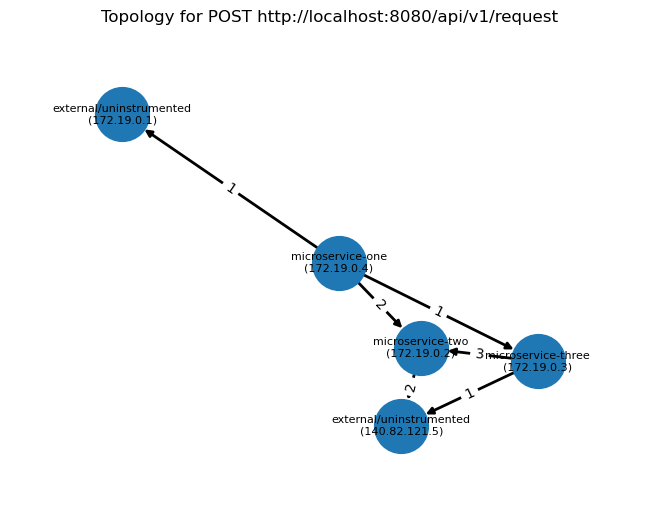

In [38]:
draw_network(G)

---

### **4. Capacity Analysis**

In this section, we will perform the capacity analysis process using the topology inferred in the previous section. The capacity analysis process consists of two primary steps: LAMA creation and analysis. The LAMA creation step consists of creating a LAMA based on the topology inferred in the previous section. The analysis step consists of analyzing the LAMA to obtain the capacity of the system.

The process of analysis is based on [this paper](https://biblioteca.sistedes.es/submissions/descargas/2022/JCIS/2022-JCIS-032.pdf) from Fresno-Aranda et al. where they use a tool called Smart-Lama to perform capacity abalysis. Thus, before starting, we will define some helper constants and functions that will be used throughout the capacity analysis process.

In [39]:
# Some auxiliary constants and variables
SECONDS_PER_MONTH= 60*60*24*30
SECONDS_PER_DAY= 60*60*24
MAXIMUM_COST= 99999999.99

serviceName = 'test_infrastructure-' + G.graph['name'].replace(' ', '_').replace('/', '_').replace(':', '_').replace('.', '_').replace('?', '_').replace('&', '_').replace('=', '_').replace('-', '_')

api_url = 'https://smart-lama.services.governify.io/api/v2/lamas'
urlBase= api_url+'/'+serviceName+'/operations/'

We will now create CRUD wrappers using the [requests](https://docs.python-requests.org/en/latest/) library and [json](https://docs.python.org/3/library/json.html) library. The following code block defines the functions:

In [40]:
# LAMA CRUD wrappers 
def post_lama(ldl):
    headers = {'Content-Type': 'application/json'}
    json_response = requests.post(api_url, data=json.dumps(ldl), headers=headers)
    res = json_response.status_code
    return res

def put_lama(ldl):
    headers = {'Content-Type': 'application/json'}
    json_response = requests.put(api_url+'/'+serviceName, data=json.dumps(ldl), headers=headers)
    res = json_response.status_code
    return res

def delete_lama():
    json_response = requests.delete(api_url+'/'+serviceName)
    res = json_response.status_code
    return res

Now, we will define functions that will help us answer the following capacity questions:

* What is the maximum number of requests that can be made within a given time window?
* What is the maximum quota per month for a given plan without the risk of exceeding the API limitations?
* Which is the minimum cost to serve a given number of requests?
* What is the minimum time to serve a given number of requests?
* What is the minimum time to serve a given number of requests for less than a given price?

In [41]:
# Operation wrappers
def maxRequests(timeWindow,maximumCost=MAXIMUM_COST,useOvg="false"):
    api_q= urlBase+'maxRequests?OpEx={0}&time={1}&useOvg={2}'.format(maximumCost,timeWindow,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def maxRequestsKeys(timeWindow,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg="false"):
    api_q= urlBase+'maxRequests?K-E1-Basic={0}&K-E1-Premium={1}&K-E2-Silver={2}&K-E2-Gold={3}&time={4}&useOvg={5}'.format(keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,timeWindow,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minCost(numRequests,numSeconds=SECONDS_PER_MONTH,useOvg="false"):
    api_q= urlBase+'minCost?reqL={0}&time={1}&useOvg={2}'.format(numRequests,numSeconds,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minTime(numRequests,maximumCost=MAXIMUM_COST,useOvg="false"):
    api_q= urlBase+'minTime?reqL={0}&OpEx={1}&useOvg={2}'.format(numRequests, maximumCost,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)

def minTimeKeys(numRequests,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg="false"):
    api_q= urlBase+'minTime?reqL={0}&K-E1-Basic={1}&K-E1-Premium={2}&K-E2-Silver={3}&K-E2-Gold={4}&useOvg={5}'.format(numRequests,keysE1Basic,keysE1Premium,keysE2Silver,keysE2Gold,useOvg)
    res = requests.get(api_q).json()
    result = res['result']
    response = res['response']
    return (result, response)


#### **4.1 LAMA creation**

From the inferred topology, we can create a LAMA in Smart-Lama. To do so, we will use the CRUD wrappers defined above, but first we need to define the lama using the domain specific language (DSL) defined in the paper. The following code block declares the LAMA according to the DSL:

In [42]:
# Description of the LAMA to analyse
lama_dl = {
    "id": serviceName,
    "services": internal_services,
    "external": external_services,
    "entry": entry,
    "relationships": relationships,
    "pricings": [
        {
            "external": external_services[0],
            "plans": [
                {
                    "name": "Authenticated",
                    "cost": 0.0,
                    "rate": 5000,
                    "rateunit": 86400,
                    "quota": 5000,
                    "quotaunit": 86400,
                    "ovg": 0.0
                }
            ]
        }
    ]
}

We can now use the CRUD wrappers to POST the LAMA to Smart-Lama and start the analysis. The following code block posts the LAMA to Smart-Lama:

In [43]:
status = post_lama(lama_dl)
if status == 201:
    print('The LAMA for ' + serviceName + ' is succesfully created')
elif status == 409:
   # update/put the resource
    status_2 = put_lama(lama_dl)
    if status_2 == 204:
        print('The LAMA for ' + serviceName + ' was successfully updated')
    else:
        print('There was an error when updating the LAMA for ' + serviceName)
    #print('The LAMA for ' + serviceName + ' is already created')
else:
    print('There was an error when creating the LAMA for ' + serviceName)

The LAMA for test_infrastructure-POST_http___localhost_8080_api_v1_request is succesfully created


#### **4.2 Analysis**

Once the LAMA has been created, we can now perform the analysis. We will start answering the questions defined in the previous section. The following code block answers the first question: *What is the maximum number of requests that can be made within a given time window?*

We have set a time window of 1 minute. The result is shown after executing the code block below. Note that we have commented the full response, but you can uncomment it in case you want to see more details.

In [44]:
# Q1. What is the maximum number of requests that can be made in 1 minute? 

(MR,fullResponse) = maxRequests(60)
print ('The maximum number of requests than can be made in 1 minute is {0} '.format(MR))
#print (fullResponse)

The maximum number of requests than can be made in 1 minute is 4545 


The following code block answers the second question: *What is the maximum quota per month for a given plan without the risk of exceeding the API limitations?*

In [45]:
# Q2. What is the maximum quota per month for a given plan without the risk of exceeding the API limitations?

c=10
t=SECONDS_PER_MONTH
(MR,fullResponse) = maxRequests(t, c)
print ('The maximum quota per month is {0}'.format(MR))
#print (fullResponse)

The maximum quota per month is 136363


The following code block answers the third question: *Which is the minimum cost to serve a given number of requests?*
Note that since we are using the free plan from GitHub API, the cost will be 0.

In [46]:
# Q3. What is the minimum cost to serve 5 requests?

n= 5
(mc,fullResponse) = minCost(n)
print ('The minimum cost to serve {0} requests is {1}'.format(n, mc, '0:.2f'))
#print (fullResponse)

The minimum cost to serve 5 requests is 0


The following code block answers the fourth question: *What is the minimum time to serve a given number of requests?*
Note that since GitHub does not provide a rate limit (only a hard limit), the time will be minimum.

In [47]:
# Q4. What is the minimum time to serve 300 requests?

n= 300
(mt,fullResponse) = minTime(n)
if (mt=="Unsatisfiable"):
    print ('It is not possible to serve {0} requests'.format(n, '0:.2f'))
else:
    print ('The minimum time to serve {0} requests is {1} seconds'.format(n, mt, '0:.2f'))
#print (fullResponse)

The minimum time to serve 300 requests is 1 seconds


The following code block answers the fifth question: *What is the minimum time to serve a given number of requests for less than a given price?* This question's answer is the same as the previous one, since there is no cost associated with the requests.

In [48]:
# Q5. What is the minimum time to serve 300 requests for less than $20?

n= 300
cost= 20
(mt,fullResponse) = minTime(n, cost)
if (mt=="Unsatisfiable"):
    print ('It is not posible to serve {0} requests in less than {1} seconds for less than {2}.'.format(n, mt, cost))
else:
    print ('The minimum time to serve {0} requests is {1} seconds'.format(n, mt, '0:.2f'))
#print (fullResponse)

The minimum time to serve 300 requests is 1 seconds


Finally, after completing the analysis, we delete the LAMA from Smart-Lama.

In [49]:
delete_lama()

204

#### **4.3 Results**

The results obtained from the analysis are shown below:

1. _What is the maximum number of requests that can be made within a given time window?_ (1 minute)
    * **4545 requests**. <br><br>

2. _What is the maximum quota per month for a given plan without the risk of exceeding the API limitations?_ (Free plan)
    * **136363 requests per month**.<br><br>

3. _Which is the minimum cost to serve a given number of requests?_ (Free plan)
    * **0.00**.<br><br>

4. _What is the minimum time to serve a given number of requests?_ (Free plan)
    * **1 second**.<br><br>

5. _What is the minimum time to serve a given number of requests for less than a given price?_ (Free plan)
    * **1 second**.<br><br>

This analysis demonstrates the applicability of telemetry to the capacity analysis process. By leveraging RESTSense, we have been able to infer the inputs required for capacity analysis based on the telemetry data. This contributes to the automation of the capacity analysis process and enhances our understanding of system behavior. Furthermore, the use of RESTSense in combination with Smart-Lama allows us to perform capacity analysis at runtime and in a continuous manner, which is crucial for ensuring the smooth functioning and optimal performance of these systems.

---

### **5. Limitations**

Upon completion of the analysis, we have identified the following limitations:

1. It is not possible to automatically obtain the plans from external APIs, they must be entered manually in the system.
2. If not all services are implemented, it is not possible to identify external services when the infrastructure is distributed over several servers with different network identifiers.
3. The need of infrastructure to deploy the RESTSense Collector may be considered a limitation, since it may require additional resources from the system where it is deployed, leading to a potential increase of the infrastructure costs.
---

### **6. Conclusions**

In this notebook, we have demonstrated the applicability of telemetry to the capacity analysis process. To this end, we have leveraged RESTSense to infer the inputs required for capacity analysis based on the telemetry data. This contributes to the automation of the capacity analysis process and enhances our understanding of system behavior. Furthermore, the use of RESTSense in combination with Smart-Lama allows us to perform capacity analysis at runtime and in a continuous manner, which is crucial for ensuring the smooth functioning and optimal performance of these systems.

RESTSense brings us one step closer to the automation of the capacity analysis process, and due to it exporting valuable telemetry data, may have potential applications in other areas. The usage of RESTSense telemetry data for machine learning purposes is feasible, and may be used to predict the capacity of the system, or to detect anomalies in the system behavior.

Although we have successfully demonstrated the applicability of telemetry to the capacity analysis process, we have also identified some limitations, which are left as future work. These limitations include the need to manually enter the plans from external APIs, the inability to identify external services when the infrastructure is distributed over several servers with different network identifiers, and the need of infrastructure to deploy the RESTSense Collector, which may require additional resources from the system where it is deployed, leading to a potential increase of the infrastructure costs.

These limitations could be addressed by extending the functionality of RESTSense. For instance, the plans from external APIs could be automatically obtained by leveraging RESTSense to extract the information from APIs that provide this information by means of standards and specifications such as [SLA4OAI](https://sla4oai.specs.governify.io/). Furthermore, RESTSense could implement agents for different languages other than Node.js, which would allow to identify external services when the infrastructure is distributed over several servers with different network identifiers. Finally, although the RESTSense datamodel specification is designed to input minimum overhead, the infrastructure costs may be affected anyway. This could be solved by providing a Software as a Service (SaaS) solution, where the RESTSense Collector is deployed in the cloud, thus reducing the infrastructure costs of monitored systems.

In conclusion, RESTSense is a promising tool that can be used to automate the capacity analysis process and enhance our understanding of system behavior. Furthermore, RESTSense may have potential applications in other areas, such as machine learning.